In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
from timeit import timeit
from IPython.display import display
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split
from joblib import dump, load
from imblearn.under_sampling import RandomUnderSampler
import shap

In [2]:
from compiledataset import load_dataset, compile_dataset

PATH = "/home/hampus/miun/master_thesis/Datasets"

datasets = {}

# dataset: pd.DataFrame = load_dataset(PATH + "/ORNL", "data_a.csv")
# dataset["remarks"] = "No DLC available"
# datasets["ROAD"] = dataset.to_dict("records")

# dataset: pd.DataFrame = load_dataset(PATH + "/Survival", "data.csv") #, "Malfunction_dataset_SONATA")
# dataset["remarks"] = "-"
# datasets["Survival"] = dataset.to_dict("records")

# dataset: pd.DataFrame = load_dataset(PATH + "/Hisingen", "data.csv", "Vehicle_F-Model_2-Fabrication_attack-Sample_1")
# dataset["remarks"] = "-"
# datasets["Hisingen"] = dataset.to_dict("records")


# df = compile_dataset(datasets)
# dump(df, "dumped_datasets/road_masq.joblib")
# df: pd.DataFrame = load("dumped_datasets/survival_all.joblib")
df: pd.DataFrame = load("dumped_datasets/road_all.joblib")
# df: pd.DataFrame = load("dumped_datasets/road_masq.joblib")
# df: pd.DataFrame = load("dumped_datasets/hisingen_all.joblib")

# df.drop(columns=["dcs", "dt", "dt_data"], inplace=True, errors="ignore")
df.drop(columns=["data", "data_dec", "ID", "DLC", "t"], inplace=True, errors="ignore")
df.drop(columns=["d0", "d1", "d2", "d3", "d4", "d5", "d6", "d7"], inplace=True, errors="ignore")

dataset = None # Release memory, as it isn't used for now
datasets = None

display(df)

,dcs,dcs_ID,dt,dt_ID,dt_data,name,class,dataset,type,Label
0,0.365919,0.041588,4.073523e-04,0.009999,15.838963,correlated_signal_attack_1,unknown,ROAD,fabr,0
1,0.312500,0.025444,1.019955e-03,0.009999,0.020000,correlated_signal_attack_1,unknown,ROAD,fabr,0
2,0.328125,0.000000,1.072884e-06,0.019998,0.003414,correlated_signal_attack_1,unknown,ROAD,fabr,0
3,0.296875,0.032718,2.026558e-06,0.009999,0.065284,correlated_signal_attack_1,unknown,ROAD,fabr,0
4,0.515625,0.076563,9.536743e-07,0.009998,0.382671,correlated_signal_attack_1,unknown,ROAD,fabr,0
...,...,...,...,...,...,...,...,...,...,...
1696058,0.328125,0.000000,1.192093e-06,0.050870,0.050870,reverse_light_on_attack_3,unknown,ROAD,fabr,0
1696059,0.125000,0.000000,9.977818e-04,0.019898,0.019898,reverse_light_on_attack_3,unknown,ROAD,fabr,0
1696060,0.359375,0.000000,2.145767e-06,0.010723,0.010723,reverse_light_on_attack_3,unknown,ROAD,fabr,0
1696061,0.515625,0.109375,9.536743e-07,0.025351,0.700769,reverse_light_on_attack_3,unknown,ROAD,fabr,0


In [34]:
# df = df.loc[df["type"] != "masq"]
# df = df.loc[(df["type"] == "fuzz") | (df["type"] == "none")]

In [3]:
X_train = df.drop(columns="Label")
y_train = df["Label"]

df = None # Release memory

# Split dataset into training and test data, stratify by the name of the dataset
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=0, shuffle=True, stratify=X_train["name"])

In [4]:
# rus = RandomUnderSampler(random_state=0)
# X_train, y_train = rus.fit_resample(X_train, y_train)
# X_test, y_test = rus.fit_resample(X_test, y_test)
# bintr = np.bincount(y_train)
# binte = np.bincount(y_test)
# print(f"Labels\t\tTraining\tTesting\nNormal\t\t{bintr[0]}\t\t{binte[0]}\nAttack\t\t{bintr[1]}\t\t{binte[1]}")

Labels		Training	Testing
Normal		21479		9265
Attack		21479		9265


In [4]:
X_train.drop(columns=["type", "dataset", "name", "class"], inplace=True, errors="ignore")
X_test.drop(columns=["type", "dataset", "name", "class"], inplace=True, errors="ignore")

Deep Neural Network

In [5]:
from pp_tools import scale_dataset

X_train_original = X_train.copy()
X_test_original = X_test.copy()

X_combined = pd.concat([X_train, X_test])

scale_dataset(X_combined)

test_len = len(X_test)
X_test = X_combined.iloc[-test_len:]
X_train = X_combined.iloc[:-test_len]

X_combined = None # Release memory

In [6]:
import keras
from keras import layers

dnn = keras.models.load_model("dnn_all_road_imbalanced")

# dnn = keras.models.Sequential(
#     [
#         keras.Input(shape=(len(X_train.columns),), name="input"),
#         layers.Dense(11, activation='relu', name="layer_1", kernel_initializer="glorot_normal"),
#         layers.Dense(23, activation='relu', name="layer_2", kernel_initializer="glorot_normal"),
#         layers.Dense(7, activation='relu', name="layer_3", kernel_initializer="glorot_normal"),
#         layers.Dense(1, activation='sigmoid', name="output", kernel_initializer="glorot_normal")
#     ]
# )

# dnn.compile(
#     optimizer="adam",  # Optimizer rmsprop
#     # Loss function to minimize
#     loss=keras.losses.BinaryCrossentropy(),
#     # List of metrics to monitor
#     metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.Recall(), keras.metrics.FalseNegatives()],
# )

# val_percent = int(len(y_train) * 0.1)
# X_val = X_train.sample(val_percent, random_state=0)
# y_val = y_train.loc[X_val.index]
# X_train = X_train.loc[~X_train.index.isin(X_val)]
# y_train = y_train.loc[~y_train.index.isin(X_val)]


# from sklearn.utils import class_weight
# class_weights = class_weight.compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
# class_weights = dict(enumerate(class_weights))

# def create_class_weight(labels_dict, mu=0.15):
#     total = np.sum(list(labels_dict.values()))
#     keys = labels_dict.keys()
#     class_weight = dict()
    
#     for key in keys:
#         score = math.log(mu*total/float(labels_dict[key]))
#         class_weight[key] = score if score > 1.0 else 1.0
    
#     return class_weight


# dnn.fit(
#     X_train,
#     y_train,
#     batch_size=200,
#     epochs=20,
#     validation_data=(X_val, y_val),
#     callbacks=[keras.callbacks.EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)]
# )

# dnn.save("dnn_masq_road")

# results = dnn.evaluate(X_test, y_test, batch_size=128)
# print("test loss, test acc:", results)

In [7]:
from sklearn.metrics import cohen_kappa_score, f1_score, accuracy_score, matthews_corrcoef

pred_train = np.round(dnn.predict(X_train))

f1_scores = f1_score(y_train, pred_train, average='weighted')
print("Training F1:  %0.4f (+/- %0.4f)" % (f1_scores.mean(), f1_scores.std()))

proba_test = dnn.predict(X_test)
pred_test = np.round(proba_test)



acc_scores = accuracy_score(y_test, pred_test)
print("Testing Accuracy:  %0.4f (+/- %0.4f)" % (acc_scores.mean(), acc_scores.std()))

f1_scores = f1_score(y_test, pred_test, average='weighted')
print("Testing F1:  %0.4f (+/- %0.4f)" % (f1_scores.mean(), f1_scores.std()))

matt_scores = matthews_corrcoef(y_test, pred_test)
print("Testing Matthews corr:  %0.4f (+/- %0.4f)" % (matt_scores.mean(), matt_scores.std()))

kappa_scores = cohen_kappa_score(y_test, pred_test)
print("Kappa score:  %0.4f(+/- %0.4f)" % (kappa_scores.mean(), kappa_scores.std()))

Training F1:  0.9977 (+/- 0.0000)
Testing Accuracy:  0.9977 (+/- 0.0000)
Testing F1:  0.9977 (+/- 0.0000)
Testing Matthews corr:  0.9419 (+/- 0.0000)
Kappa score:  0.9403(+/- 0.0000)


In [8]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
def plot_confusion_matrix(y_test, pred, name, cbar=True, loc="right"):
    cm_norm = confusion_matrix(y_test, pred, normalize="true")
    cm = confusion_matrix(y_test, pred)
    annots = pd.DataFrame(cm_norm).applymap(lambda x: str(round(x, 3)))
    annots += pd.DataFrame(cm).applymap(lambda x: f"\n({str(x)})")
    plt.figure(dpi=100)
    sns.heatmap(cm_norm, annot=annots, fmt="s", square=True, vmin=0, vmax=1,
        xticklabels=["normal", "attack"], yticklabels=["normal", "attack"], cmap="GnBu", cbar=cbar,
        cbar_kws={"location": loc}, annot_kws={"fontsize": "large"})
    # plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    # plt.savefig(f"../images/performance/dnn_survival_balanced_{name}.pdf", dpi=300, bbox_inches="tight")
    plt.show()

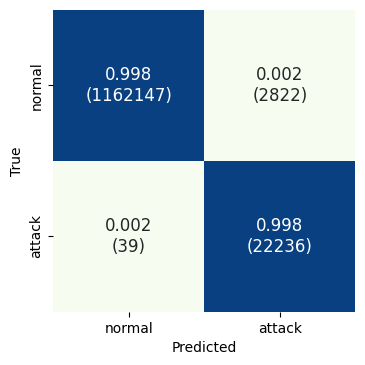

In [9]:
# from plot_tools import plot_confusion_matrix

plot_confusion_matrix(y_train, pred_train, "train", cbar=False)

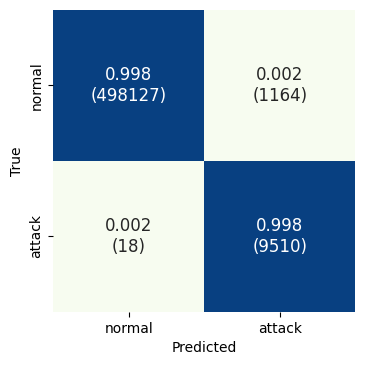

In [10]:
plot_confusion_matrix(y_test, pred_test, "test_nobar", cbar=False)

In [ ]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, pred_test, normalize="true"))
print(confusion_matrix(y_test, pred_test))

In [ ]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(y_test, proba_test, name="DNN")

In [11]:
import shap

X_sample = pd.concat([X_train[y_train == 1].sample(50, random_state=0), X_train[y_train == 0].sample(50, random_state=0)]).values

exp = shap.KernelExplainer(dnn, data=X_sample)
print(exp.expected_value)

[0.50004214]


In [12]:
from shap_tools import *

max_samples = int(min(len(X_train), 600) / 2)

X_exp = pd.concat([X_train[y_train == 1].sample(max_samples, random_state=0), X_train[y_train == 0].sample(max_samples, random_state=0)])

# X_exp = X_train.sample(min(len(X_train), 600), random_state=0)
y_exp = y_train[X_exp.index]
X_exp_original = X_train_original.loc[X_exp.index]
# print(X_exp)
# print(X_exp_original)

# Make sure that the ingested SHAP model (a TreeEnsemble object) makes the
# same predictions as the original model
# assert np.abs(exp.model.predict(X_exp) - dnn.predict_proba(X_exp)).max() < 1e-4


# # Make sure the SHAP values sum up to the model output (this is the local accuracy property)
# assert np.abs((shap_all.base_values + shap_all.values).sum(1) - clf.predict_proba(X_train)).max() < 1e-4

# print(len(X_train.loc[y_train != pred]))
# print(len(X_train.loc[y_train == pred]))
# shap_false = get_explanation(exp, X_train.loc[y_train != pred])
# shap_FP = get_explanation(exp, X_train.loc[(y_train != pred) & (pred == 1)])
# shap_FN = get_explanation(exp, X_train.loc[(y_train != pred) & (pred == 0)])
# shap_true = get_explanation(exp, X_train.loc[y_train == pred])
# shap_TP = get_explanation(exp, X_train.loc[(y_train == pred) & (pred == 1)])
# shap_TN = get_explanation(exp, X_train.loc[(y_train == pred) & (pred == 0)])

In [13]:
shap_all = get_explanation(exp, X_exp)
# dump(shap_all, "dnn_survival_all_shap")

100%|██████████| 600/600 [00:17<00:00, 33.44it/s]


In [ ]:
X_test_check = X_test_original.sample(10, random_state=18)
y_test_check = y_test.loc[X_test_check.index]
pred_check = pred_test[X_test_check.index].T[0]

df_check = X_test_check
df_check["Label"] = pred_check
df_check["Label"] = df_check["Label"].astype(np.int64)
df_check["Label"].replace({0: "normal", 1: "attack"}, inplace=True)
df_check.rename(columns = {'dcs_ID': 'A', 'dt_ID': 'B'}, inplace = True)
df_check = df_check.reset_index()
df_check["A"] = df_check["A"].apply(lambda x: round(x, 3))
df_check["B"] = df_check["B"].apply(lambda x: round(x*1000, 2))
# df_check = pd.DataFrame(df_check[["dcs_ID", "dt_ID"]], )
# pred_check = pd.Series(pred_check, name="Label")


display(df_check[["A", "B", "Label"]])

In [ ]:
X_test_sample = X_test_original.sample(10, random_state=11)
y_test_sample = y_test.loc[X_test_sample.index]
pred_sample = pred_test[X_test_sample.index].T
print(X_test_sample)
print(y_test_sample)
print(pred_sample)

# 0     10    0
# 0.031 10    0
# 0.015 20    0
# 0.3   1     1
# 0     0.56  1
# 0     12    0
# 0.031 20    0
# 0     2.4   1
# 0.45  180   1
# 0.61  1500  1

In [ ]:
# shap_all.feature_names = ["T", "A", "C", "B", "E"]

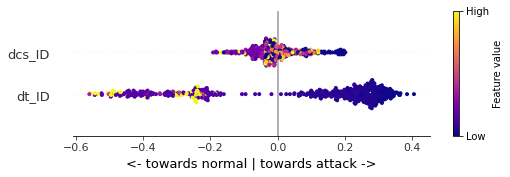

In [15]:
# plot_beeswarm(shap_all)
def plot_beeswarm2(exp_obj):
    vis = shap.plots.beeswarm(exp_obj, show=False, max_display=20, color=plt.get_cmap("plasma"), order=[1, 3], color_bar=False)
    # plt.gcf().axes[-1].set_aspect(100)
    # plt.gcf().axes[-1].set_box_aspect(100)
    cbar = plt.colorbar(plt.cm.ScalarMappable(cmap="plasma"), label="Feature value")
    cbar.set_ticks([0, 1])
    cbar.set_ticklabels(["Low", "High"])
    plt.xlabel("<- towards normal | towards attack ->")
    return vis

plot_beeswarm2(shap_all)

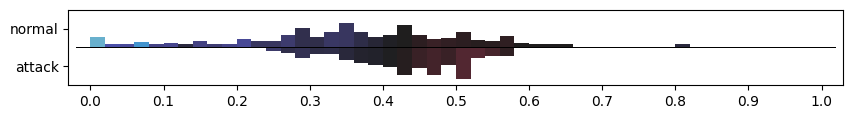

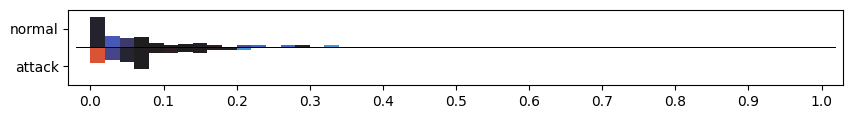

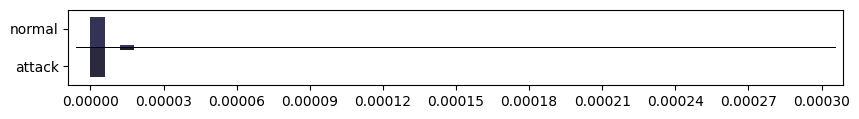

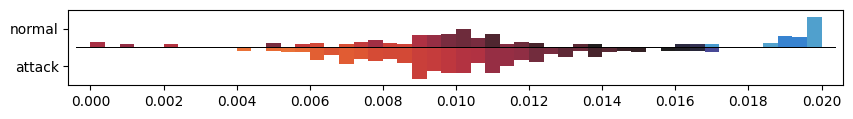

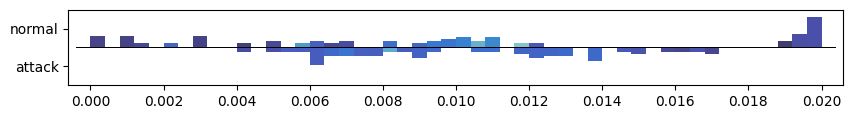

In [16]:
import matplotlib
from matplotlib.patches import Rectangle
def cust_exp(df_exp: pd.DataFrame, shap_all: shap.Explanation, feature, scale):
    df_exp["Label"].replace({0: "normal", 1: "attack"}, inplace=True)
    shap_exp = shap_all.values[:,df_exp.columns.get_loc(feature)]

    mask = (df_exp[feature] >= scale[0]) & (df_exp[feature] < scale[1])

    attack_outliers = shap_exp[~mask & (df_exp["Label"] == "attack")]
    normal_outliers = shap_exp[~mask & (df_exp["Label"] == "normal")]

    shap_exp = shap_exp[mask]
    df_exp = df_exp[mask].copy()
    
    scaler = max(abs(shap_exp.min()), abs(shap_exp.max()))
    shap_hues = shap_exp / scaler
    shap_hues = (shap_hues + 1) * shap_all.base_values # [0]

    cmap = sns.color_palette("icefire", as_cmap=True)
    norm = plt.Normalize(vmin=0, vmax=1)
    palette = {h: cmap(h) for h in shap_hues}

    df_exp["shap_hues"] = shap_hues
    
    normal_values = df_exp.loc[df_exp["Label"] == "normal", [feature, "shap_hues"]]
    attack_values = df_exp.loc[df_exp["Label"] == "attack", [feature, "shap_hues"]]
    
    normal_hist, normal_bins = np.histogram(normal_values[feature], bins=50, range=(scale[0], scale[1]))
    attack_hist, attack_bins = np.histogram(attack_values[feature], bins=50, range=(scale[0], scale[1]))

    fig, ax = plt.subplots(dpi=100, figsize=(10, 1))
    
    max_bar = max(normal_hist.max(), attack_hist.max())
    normal_hist = normal_hist / max_bar
    attack_hist = attack_hist / max_bar

    # normal_cont = ax.bar(normal_bins[:-1], normal_hist, width=(scale[1] - scale[0])/50, align="edge")
    # attack_cont = ax.bar(attack_bins[:-1], -attack_hist, width=(scale[1] - scale[0])/50, align="edge")

    normal_cont = ax.bar(normal_bins[:-1], np.tanh(normal_hist*1.0)+0.04, width=(scale[1] - scale[0])/50, align="edge")
    attack_cont = ax.bar(attack_bins[:-1], np.tanh(-attack_hist*1.0)-0.04, width=(scale[1] - scale[0])/50, align="edge")


    # Colorize and shift
    prev_edge = 0
    for i in range(1, len(normal_bins)):
        normal_hues_mean = normal_values.loc[(normal_values[feature] >= normal_bins[prev_edge]) & (normal_values[feature] < normal_bins[i]), "shap_hues"].fillna(0.5).mean()
        attack_hues_mean = attack_values.loc[(attack_values[feature] >= attack_bins[prev_edge]) & (attack_values[feature] < attack_bins[i]), "shap_hues"].fillna(0.5).mean()

        normal_cont.patches[i - 1].set_facecolor(cmap(normal_hues_mean))
        attack_cont.patches[i - 1].set_facecolor(cmap(attack_hues_mean))
        
        normal_cont.patches[i - 1].set_y(0.02)
        attack_cont.patches[i - 1].set_y(-0.02)

        prev_edge = i

    ticks = np.linspace(scale[0], scale[1], 11)
    tick_unit = ticks[1]
    ax.set_xlim(scale[0]-0.3*tick_unit, scale[1]+0.3*tick_unit)
    ax.set_xticks(ticks=ticks) #, labels=map(lambda x: format(x, '.2f'), np.linspace(0, 0.02, 11)))
    ax.set_ylim(-1, 1)
    ax.set_yticks(ticks=[-0.5, 0.5], labels=["attack", "normal"])

    # ax.axhline(y=0, color="black", linewidth=1, zorder=-1)
    ax.add_artist(Rectangle((scale[0]-tick_unit*0.2, -0.02), width=scale[1]+tick_unit*0.4, height=0.04, color="black", linewidth=0))

    plt.show()

cust_exp(pd.concat([X_exp_original, y_exp], axis=1), shap_all, "dcs", scale=(0, 1))
cust_exp(pd.concat([X_exp_original, y_exp], axis=1), shap_all, "dcs_ID", scale=(0, 1))
cust_exp(pd.concat([X_exp_original, y_exp], axis=1), shap_all, "dt", scale=(0, 0.0003))
cust_exp(pd.concat([X_exp_original, y_exp], axis=1), shap_all, "dt_ID", scale=(0, 0.02))
cust_exp(pd.concat([X_exp_original, y_exp], axis=1), shap_all, "dt_data", scale=(0, 0.02))

In [58]:
X_exp_original["dcs_ID"].max()

0.65625

22.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.


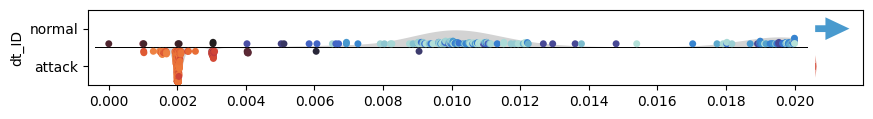

27.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
24.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.


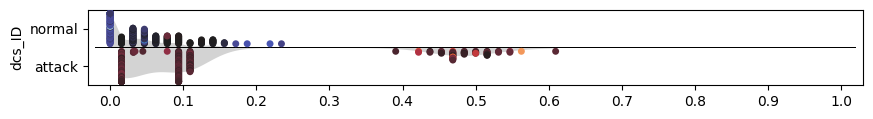

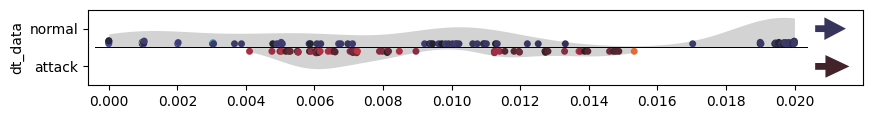

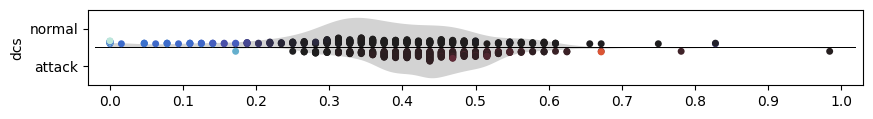

26.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.


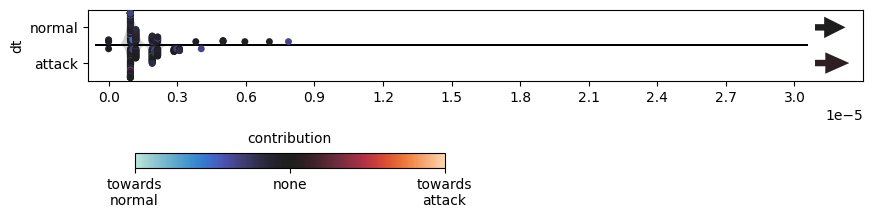

In [16]:
import matplotlib
from matplotlib.patches import Rectangle
def plot_test(df_exp: pd.DataFrame, shap_all: shap.Explanation, feature, trim, y_squish=10, scale=1, colorbar=False, y_size=1):
    df_exp["Label"].replace({0: "normal", 1: "attack"}, inplace=True)
    shap_exp = shap_all.values[:,df_exp.columns.get_loc(feature)]

    # vvv Masking outliers vvv

    mask = (df_exp[feature] >= trim[0]) & (df_exp[feature] < trim[1])
    attack_outliers = shap_exp[~mask & (df_exp["Label"] == "attack")]
    normal_outliers = shap_exp[~mask & (df_exp["Label"] == "normal")]

    shap_exp = shap_exp[mask]
    df_exp = df_exp[mask]

    # ^^^ Masking outlier ^^^

    fig, ax = plt.subplots(dpi=100, figsize=(80, y_squish))
    
    cmap_name = "icefire"
    violin_color = "lightgray"

    scaler = max(abs(shap_exp.min()), abs(shap_exp.max()))
    shap_hues = shap_exp / scaler
    shap_hues = (shap_hues + 1) * shap_all.base_values
    
    cmap = sns.color_palette(cmap_name, as_cmap=True)
    norm = plt.Normalize(vmin=0, vmax=1)
    palette = {h: cmap(h) for h in shap_hues}

    values = df_exp[feature]
    # feature_min = values.min()
    # feature_max = values.max()
    # values = (values - values.min()) / (values.max() - values.min())
    label = df_exp["Label"]

    sns.swarmplot(x=values, y=label, order=["normal", "attack"],
        hue=shap_hues, orient="h", palette=palette,
        size=5)
    
    # Change offset on dots for normal (0)
    offsets = ax.collections[0].get_offsets()
    offsets = [[elem[0], -abs(elem[1] - 0) - 0.05] for elem in offsets]
    ax.collections[0].set_offsets(offsets)

    # Change offset on dots for attack (1)
    offsets = ax.collections[1].get_offsets()
    offsets = [[elem[0], abs(elem[1] - 1) + 0.05] for elem in offsets]
    ax.collections[1].set_offsets(offsets)

    fig.set_size_inches(10, y_size)

    sns.violinplot(x=values, y=[0]*label.size, hue=label, split=True, hue_order=["normal", "attack"],
        orient="h",  showfliers=False, scale="count", bw=0.2, gridsize=1000, linewidth=0, color=violin_color,
        cut=0, inner=None)
    
    ax.legend_.remove()
    
    for violin in ax.findobj(matplotlib.collections.PolyCollection):
        violin.set_facecolor("lightgray")
    

    if colorbar:
        cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap_name), location="bottom", shrink=0.4, anchor=(0.10, 0), pad=0.4)
        cbar.set_label("contribution", labelpad=-55)
        cbar.set_ticks([0, 0.5, 1])
        cbar.set_ticklabels(["towards\nnormal", "none", "towards\nattack"])

        # plt.arrow(0, 0.5, 1, 0, facecolor="black",
        #     width=0.07, head_length=0.7, head_width=0.2,
        #     length_includes_head=True)

    # f_dict = {"dcs": "A", "dcs_ID": "A", "dt": "C", "dt_ID": "B", "dt_data": "E"}
    # feature = f_dict[feature]
    # ax.set_title(f"How the RF-model classifies data - feature: {feature}")
    # ax.set_title(feature)
    # feature = feature + " (ms)" if feature[0:2] == "dt" else feature
    
    ticks = np.linspace(trim[0], trim[1], 11)

    # vvv ARROWS vvv

    if attack_outliers.size != 0:
        attack_outliers /= max(abs(attack_outliers.min()), abs(attack_outliers.max()))
        attack_outliers = (attack_outliers + 1) * shap_all.base_values

    if normal_outliers.size != 0:
        normal_outliers /= max(abs(normal_outliers.min()), abs(normal_outliers.max()))
        normal_outliers = (normal_outliers + 1) * shap_all.base_values

    s_last = ax.get_xticks()[-2]
    last = ax.get_xticks()[-1]
    
    largest_outliers = max(len(normal_outliers), len(attack_outliers))

    if normal_outliers.size != 0:
        # ax.text(last + (last-s_last) * 0.5, -0.28, f"{len(normal_outliers)}")
        arrow_length = 0.5 * ticks[1] * (len(normal_outliers) / largest_outliers)
        ax.arrow(ticks[-1]+ticks[1]*0.3, -0.25, arrow_length, 0,
            facecolor=cmap(normal_outliers.mean()), linewidth=0,
            width=0.09, head_length=(arrow_length)*0.7, head_width=0.3,
            length_includes_head=True)
    if attack_outliers.size != 0:
        # ax.text(last + (last-s_last) * 0.5, 0.22, f"{len(attack_outliers)}")
        arrow_length = 0.5 * ticks[1] * (len(attack_outliers) / largest_outliers)
        ax.arrow(ticks[-1]+ticks[1]*0.3, 0.25, arrow_length, 0,
            facecolor=cmap(attack_outliers.mean()), linewidth=0,
            width=0.09, head_length=(arrow_length)*0.7, head_width=0.3,
            length_includes_head=True)
    
    # ^^^ ARROWS ^^^

    ax.set_xlabel("")
    ax.set_ylabel(feature) #, rotation="vertical", x=-1, y=0.4)
    ax.set_xticks(ticks=ticks)
    ax.set_yticks(ticks=[-0.25, 0.25], labels=["normal", "attack"])
    if normal_outliers.size != 0 or attack_outliers.size != 0:
        ax.set_xlim((trim[0]-ticks[1]*0.3, trim[1]+ticks[1]))
    else:
        ax.set_xlim((trim[0]-ticks[1]*0.3, trim[1]+ticks[1]*0.3))

    ax.add_artist(Rectangle((trim[0]-ticks[1]*0.2, -0.01), width=trim[1]+ticks[1]*0.4, height=0.02, color="black", linewidth=0))
    # ax.axhline(y=0, color="black", linewidth=0.5)
    ax.margins(x=0.5)
    
    plt.savefig(f"../images/custom_exp/dnn_road_custom_{feature}.pdf", dpi=300, bbox_inches="tight")
    plt.show()

plot_test(pd.concat([X_exp_original, y_exp], axis=1), shap_all, "dt_ID", trim=(0, 0.02), scale=1000)
plot_test(pd.concat([X_exp_original, y_exp], axis=1), shap_all, "dcs_ID", trim=(0, 1), y_squish=15)
plot_test(pd.concat([X_exp_original, y_exp], axis=1), shap_all, "dt_data", trim=(0, 0.02), scale=1000)
plot_test(pd.concat([X_exp_original, y_exp], axis=1), shap_all, "dcs", trim=(0, 1), y_squish=25)
plot_test(pd.concat([X_exp_original, y_exp], axis=1), shap_all, "dt", trim=(0, 0.00003), scale=1000, y_squish=15, colorbar=True, y_size=2.1)

# plt.figure(figsize=(12, 6))
# ax1 = plt.subplot(2,3,1)
# ax2 = plt.subplot(2,3,2)
# ax3 = plt.subplot(2,3,3)
# ax4 = plt.subplot(2,1,2)
# axes = [ax1, ax2, ax3, ax4]

In [ ]:
plot_exp(pd.concat([X_exp_original, y_exp], axis=1), shap_all, "dt_ID", trim=(0, 0.02), scale=1000)
plot_exp(pd.concat([X_exp_original, y_exp], axis=1), shap_all, "dt_data", trim=(0, 0.02), scale=1000)
plot_exp(pd.concat([X_exp_original, y_exp], axis=1), shap_all, "dt", trim=(0, 0.0003), scale=1000, y_squish=20)
plot_exp(pd.concat([X_exp_original, y_exp], axis=1), shap_all, "dcs", trim=(-1, 0.7), y_squish=25)
plot_exp(pd.concat([X_exp_original, y_exp], axis=1), shap_all, "dcs_ID", trim=(0, 1), y_squish=10)

In [ ]:
plot_waterfall(shap_all, 0)

In [ ]:
plot_force(shap_all[0])

In [ ]:
plot_dependence(shap_all, "dcs_ID", "dt_ID", xmax="percentile(99)")

In [ ]:
dnn_layer_1 = keras.Model(inputs=dnn.input, outputs=dnn.get_layer("layer_3").output)

dnn_layer_1.predict(X_train)

In [ ]:
exp_layer_1 = shap.KernelExplainer(dnn_layer_1, data=X_train.sample(100, random_state=1))

In [ ]:
shap_all_layer_1 = get_explanation(exp_layer_1, X_train, 100)

In [ ]:
# print(shap_all_layer_1)
shap.summary_plot(shap_all_layer_1, X_test, plot_type="bar")